# Text Classification of Political News

## Model Comparison

Adapted from: https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking.ipynb

### Getting Started

In [1]:
import google.datalab.storage as storage

from google.datalab import Context
import random, string

project = Context.default().project_id
suffix = ''.join(random.choice(string.lowercase) for _ in range(5))
bucket_name = project
bucket_path = 'gs://' + bucket_name

print('Bucket: ' + bucket_path)

Bucket: gs://news-lens


### Define Bucket

In [2]:
news_lens = storage.Bucket('news-lens')
news_lens.exists()

True

### Download Files

In [31]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

### Unzip Files

In [23]:
# import zipfile
# zipped = zipfile.ZipFile('glove.6B.zip')
# zipped.extractall()
# zipped = zipfile.ZipFile('glove.840B.300d.zip')
# zipped.extractall()
# !gunzip GoogleNews-vectors-negative300.bin.gz

### Move Files to Storage

In [32]:
# !gsutil cp GoogleNews-vectors-negative300.bin gs://news-lens
# !gsutil cp glove.6B.50d.txt gs://news-lens
# !gsutil cp glove.6B.100d.txt gs://news-lens
# !gsutil cp glove.6B.200d.txt gs://news-lens
# !gsutil cp glove.6B.300d.txt gs://news-lens
# !gsutil cp glove.840B.300d.txt gs://news-lens

### Check Storage

In [4]:
shared_bucket = storage.Bucket('news-lens')
for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key)

GoogleNews-vectors-negative300.bin
doc.txt
glove.6B.100d.txt
glove.6B.200d.txt
glove.6B.300d.txt
glove.6B.50d.txt
glove.840B.300d.txt
para.txt


### Install Modules

In [5]:
!pip install gensim

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Import Modules

In [6]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

/usr/local/envs/py2env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load Train/Test Data

In [7]:
TRAIN_SET_PATH = news_lens.object('doc.txt')
#TRAIN_SET_PATH = news_lens.object('para.txt')

In [8]:
train_text = TRAIN_SET_PATH.read_stream()
X, y = [], []
sample = train_text.split('\n')
for line in sample:
  if '\t' in line:
    label, text = line.split('\t')
    X.append(text.split())
    y.append(label)
  else:
    print(line)
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))


total examples 3162


### Prepare Word Embeddings

In [7]:
#WORD2VEC_PATH = news_lens.object('GoogleNews-vectors-negative300.bin')
#WORD2VEC_PATH.download()

In [10]:
GLOVE_6B_50D_PATH = news_lens.object('glove.6B.50d.txt')
GLOVE_840B_300D_PATH = news_lens.object('glove.840B.300d.txt')
encoding="utf-8"

In [11]:
glove6B = GLOVE_6B_50D_PATH.read_stream()
glove840 = GLOVE_840B_300D_PATH.read_stream()

In [12]:
sample_glove6B = glove6B.split('\n')
sample_glove840 = glove840.split('\n')

In [15]:
import numpy as np
word2vec = {line.split(' ')[0]: np.array(map(float, line.split(' ')[1:]))
               for line in sample_glove6B}

In [16]:
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)
for line in sample_glove6B:
    parts = line.split(' ')
    word = parts[0].decode(encoding)
    if (word in all_words):
        nums=np.array(parts[1:], dtype=np.float32)
        glove_small[word] = nums

            
glove_big = {}
for line in sample_glove6B:
    parts = line.split(' ')
    word = parts[0].decode(encoding)
    if word in all_words:
        nums=np.array(parts[1:], dtype=np.float32)
        glove_big[word] = nums

In [17]:
# train word2vec on all the texts - both training and test set
scratch_model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(scratch_model.wv.index2word, scratch_model.wv.syn0)}

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [ ]:
# use pretrained google news vectors
# pretrain_model = gensim.models.KeyedVectors.load_word2vec_format('WORD2VEC_PATH', binary=True)
# w2v_pre = {w: vec for w, vec in zip(pretrain_model.wv.index2word, pretrain_model.wv.syn0)}

### Define Models

In [18]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [19]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
# tf-idf version of the same

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        '''
        if a word was never seen - it must be at least as infrequent
        as any of the known words - so the default idf is the max of 
        known idf's
        '''
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [20]:
# Stack extra trees classifier with embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_big_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

In [21]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small", etree_glove_small), 
    ("glove_small_tfidf", etree_glove_small_tfidf),
    ("glove_big", etree_glove_big), 
    ("glove_big_tfidf", etree_glove_big_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
]

### Run Models

In [22]:
scores = sorted([(name, cross_val_score(model, X, y, cv=5).mean()) 
                 for name, model in all_models], 
                key=lambda (_, x): -x)
print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))

model                score
-----------------  -------
svc_tfidf           0.5000
bern_nb             0.4987
bern_nb_tfidf       0.4987
svc                 0.4794
mult_nb             0.4396
mult_nb_tfidf       0.4137
glove_big           0.4013
glove_small_tfidf   0.3963
glove_big_tfidf     0.3903
w2v_tfidf           0.3893
glove_small         0.3877
w2v                 0.3842


/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


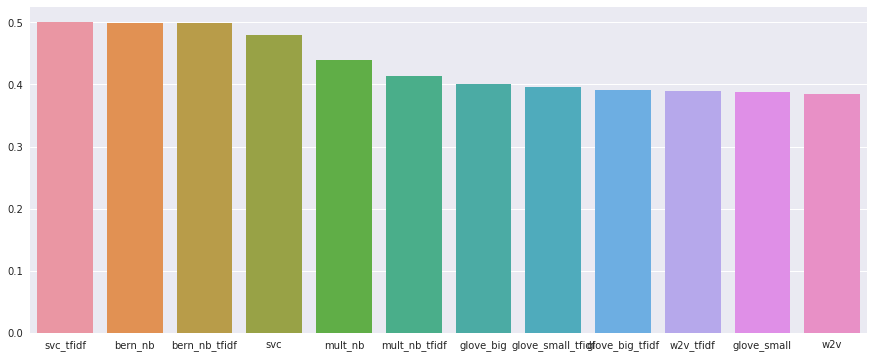

In [23]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])